In [1]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import load_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

pd.options.mode.chained_assignment = None 

Using TensorFlow backend.


In [2]:
with open("../Data/ptr_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)
    
eraslan_df = data_dict["eraslan"]
wilhelm_df = data_dict["wilhelm"]

In [4]:
new_model = load_model("../Models/basic_model_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

### Prepare data

Two datasets (eraslan and wilhelm) comprise in-vivo PTR ratios for a selection of human tissues.

I should look for more HEK datasets

In [5]:
# compute median for eraslan data
eraslan_df["ptr"] = eraslan_df.select(lambda col: col.endswith('PTR'), axis=1).apply(pd.to_numeric, errors='coerce').mean(axis=1)

/data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  


In [6]:
# encode
eraslan_df["library"] = "egfp_unmod_1"
eraslan_encoded = utils.encode_df(eraslan_df, col="utr", output_col=None, variable_len=True)

wilhelm_df["library"] = "egfp_unmod_1"
wilhelm_encoded = utils.encode_df(wilhelm_df, col="utr", output_col=None, variable_len=True)

Pearson: 0.654, p-val: 0.000, squared: 0.427, Spearman: 0.667, p-val: 0.000


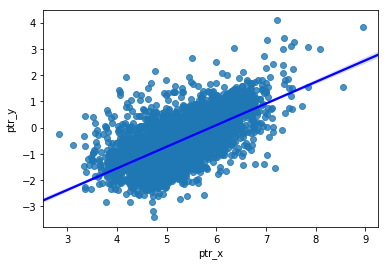

In [22]:
df = eraslan_df.merge(wilhelm_df, on = "GeneName")
x = sns.regplot(x='ptr_x', y="ptr_y", data=df, line_kws={"color":"b"}).get_figure()
utils.print_corrs(df["ptr_x"], df["ptr_y"])

### Predict

In [7]:
predictions_eraslan = new_model.predict([eraslan_encoded["seq"], eraslan_encoded["library"]])
predictions_wilhelm = new_model.predict([wilhelm_encoded["seq"], wilhelm_encoded["library"]])

In [8]:
utils.print_corrs(predictions_eraslan.reshape(-1), eraslan_df["ptr"])
utils.print_corrs(predictions_wilhelm.reshape(-1), wilhelm_df["ptr"])

Pearson: 0.144, p-val: 0.000, squared: 0.021, Spearman: 0.150, p-val: 0.000
Pearson: 0.118, p-val: 0.000, squared: 0.014, Spearman: 0.113, p-val: 0.000


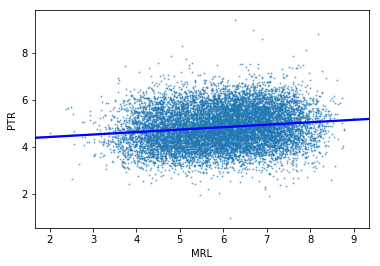

In [9]:
df = pd.DataFrame({"MRL":predictions_eraslan.reshape(-1), "PTR":eraslan_df["ptr"]})
x = sns.regplot(x='MRL', y="PTR", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

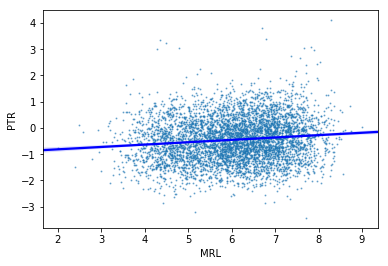

In [10]:
df = pd.DataFrame({"MRL":predictions_wilhelm.reshape(-1), "PTR":wilhelm_df["ptr"]})
x = sns.regplot(x='MRL', y="PTR", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

### Fixed length model

In [13]:
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")

In [14]:
eraslan_df_50 = eraslan_df.copy()
eraslan_df_50["utr"] = eraslan_df["utr"].str[-50:]
eraslan_encoded_50 = utils.encode_df(eraslan_df_50, col="utr", output_col=None, variable_len=True)

wilhelm_df_50 = wilhelm_df.copy()
wilhelm_df_50["utr"] = wilhelm_df["utr"].str[-50:]
wilhelm_encoded_50 = utils.encode_df(wilhelm_df_50, col="utr", output_col=None, variable_len=True)

In [15]:
predictions_eraslan = paper_model.predict(eraslan_encoded_50["seq"])
predictions_wilhelm = paper_model.predict(wilhelm_encoded_50["seq"])

In [16]:
utils.print_corrs(predictions_eraslan.reshape(-1), eraslan_df["ptr"])
utils.print_corrs(predictions_wilhelm.reshape(-1), wilhelm_df["ptr"])

Pearson: 0.102, p-val: 0.000, squared: 0.010, Spearman: 0.077, p-val: 0.000
Pearson: 0.080, p-val: 0.000, squared: 0.006, Spearman: 0.064, p-val: 0.000


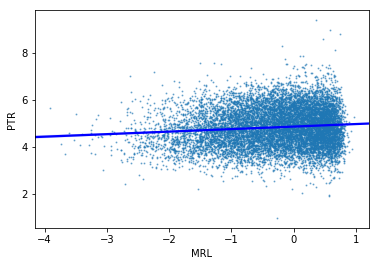

In [17]:
df = pd.DataFrame({"MRL":predictions_eraslan.reshape(-1), "PTR":eraslan_df["ptr"]})
x = sns.regplot(x='MRL', y="PTR", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

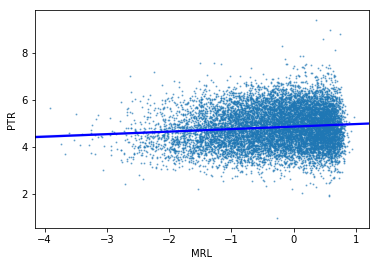

In [18]:
df = pd.DataFrame({"MRL":predictions_eraslan.reshape(-1), "PTR":eraslan_df["ptr"]})
x = sns.regplot(x='MRL', y="PTR", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

### Try to improve prediction by scoring the (canonical) TIS strength

In [8]:
eraslan_df = utils.extract_tis(eraslan_df)
wilhelm_df = utils.extract_tis(wilhelm_df) 

In [9]:
noderer_score = utils.build_tis_score_dict(replace_u=False)

In [10]:
eraslan_df["score"] = [noderer_score[tis] for tis in eraslan_df["tis"]]
wilhelm_df["score"] = [noderer_score[tis] for tis in wilhelm_df["tis"]]

In [11]:
X = np.concatenate([predictions_eraslan, np.array(eraslan_df["score"])[:, np.newaxis]], axis=1)
y = np.array(eraslan_df["ptr"])[:, np.newaxis]
# without
reg = LinearRegression().fit(X[:,0:1], y)
print("without: " + str(reg.score(X[:,0:1], y)))
#with
reg = LinearRegression().fit(X, y)
y_hat = reg.predict(X)
print("with tis score: " + str(utils.adjust_r2(utils.rSquared(y_hat.reshape(-1), y.reshape(-1)), X.shape[0], X.shape[1])))
# only noderer
reg = LinearRegression().fit(X[:,1:], y)
print("only tis score: " + str(reg.score(X[:,1:], y)))

without: 0.020850758596148825
with tis score: 0.02699217011927313
only tis score: 0.007452001090948679


In [71]:
utils.print_corrs(y.reshape(-1), y_hat.reshape(-1))

Pearson: 0.165, p-val: 0.000, squared: 0.027, Spearman: 0.169, p-val: 0.000


In [74]:
X = np.concatenate([predictions_wilhelm, np.array(wilhelm_df["score"])[:, np.newaxis]], axis=1)
y = np.array(wilhelm_df["ptr"])[:, np.newaxis]
# without
reg = LinearRegression().fit(X[:,0:1], y)
print("without: " + str(reg.score(X[:,0:1], y)))
#with
reg = LinearRegression().fit(X, y)
y_hat = reg.predict(X)
print("with tis score: " + str(utils.adjust_r2(utils.rSquared(y_hat.reshape(-1), y.reshape(-1)), X.shape[0], X.shape[1])))

without: 0.013890140295806153
with tis score: 0.014340427132000788


In [73]:
utils.print_corrs(y.reshape(-1), y_hat.reshape(-1))

Pearson: 0.121, p-val: 0.000, squared: 0.015, Spearman: 0.119, p-val: 0.000
